In [1]:
import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize 
nltk.download('punkt')

!pip install -U emojis
import emojis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
!pip install 'transformers[torch]'
from transformers import pipeline
!pip install sentencepiece

2024-04-04 16:06:08.537120: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lluneta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/lluneta/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/lluneta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:

df = pd.read_json('data/dataset_en_train.json')

In [3]:
df

,id,text,category,annotations,spacy_tokens
0,5206,THIS IS MASSIVE Australian Senator Malcolm Rob...,CONSPIRACY,[{'span_text': 'Australian Senator Malcolm Rob...,WyJUSElTIiwgIklTIiwgIk1BU1NJVkUiLCAiQXVzdHJhbG...
1,1387,“ I ’m deeply concerned that the push to vacci...,CRITICAL,[{'span_text': 'I ’m deeply concerned that the...,WyJcdTIwMWMiLCAiSSIsICJcdTIwMTltIiwgImRlZXBseS...
2,13116,2021 : They wanted to know your vaccination st...,CRITICAL,"[{'span_text': 'someone who died suddenly', 'c...",WyIyMDIxIiwgIjoiLCAiVGhleSIsICJ3YW50ZWQiLCAidG...
3,11439,Anthony Fauci once again defended brutal Chine...,CRITICAL,"[{'span_text': 'brutal Chinese lockdowns', 'ca...",WyJBbnRob255IiwgIkZhdWNpIiwgIm9uY2UiLCAiYWdhaW...
4,98,Proof has emerged showing that death from Wuha...,CRITICAL,[{'span_text': 'death from Wuhan coronavirus (...,WyJQcm9vZiIsICJoYXMiLCAiZW1lcmdlZCIsICJzaG93aW...
...,...,...,...,...,...
3995,4829,Police in Australia are warning that unvaccina...,CRITICAL,"[{'span_text': 'Police in Australia', 'categor...",WyJQb2xpY2UiLCAiaW4iLCAiQXVzdHJhbGlhIiwgImFyZS...
3996,10899,I personally do n’t believe Putin would set of...,CONSPIRACY,"[{'span_text': 'Deep State', 'category': 'AGEN...",WyJJIiwgInBlcnNvbmFsbHkiLCAiZG8iLCAiblx1MjAxOX...
3997,10637,Pfizer lied . We know that . There 's no doubt...,CRITICAL,"[{'span_text': 'Pfizer', 'category': 'AGENT', ...",WyJQZml6ZXIiLCAibGllZCIsICIuIiwgIldlIiwgImtub3...
3998,11338,""" It is utterly bizarre and inexplicable - Dr....",CRITICAL,"[{'span_text': 'Dr. John Campbell', 'category'...",WyJcIiIsICJJdCIsICJpcyIsICJ1dHRlcmx5IiwgImJpem...


## Features

In [4]:
def lexical_diversity(text):
    words = nltk.word_tokenize(text)
    return len(set(words)) / len(words)

def avg_word_length(text):
    return np.mean([len(word) for sentence in sent_tokenize(text) for word in word_tokenize(sentence)])

nlp = spacy.load("en_core_web_sm")
def proper_nouns(text, model=nlp):
    # Create doc object
    doc = model(text)
    
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    
    # Return number of proper nouns
    return pos.count('PROPN')

def punc_count(text):
    return len([w for w in text if w in string.punctuation])

#def sentiment_score(text):
    #doc = nlp(text)
    #sentiment_score = doc.sentiment
    #return sentiment_score
    
    #sentiment =  nlp.sentiment_analyzer(text)
    #return sentiment.score

    
# ---> 1 means positive
analyzer = SentimentIntensityAnalyzer()
def sentiment_score(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    #add negation "n't" (since they are seperated, sentiment score don't detect)
    sentiment = sentiment + text.count("n't")
    return sentiment

def negation_count(text):
    return text.count("n't")

    
def stop_word_count(text):
    word_tokens = word_tokenize(text) 
    stop_word = len([w for w in word_tokens if w in stopwords.words('english')])
    return stop_word

def emoji_count(text):
    return emojis.count(text)

# Sentiment Analysis with distillBert(Positive Score)
from transformers import pipeline
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student", max_length = 512, truncation = True)

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    tokenizer = tokenizer,
    return_all_scores=True)

tokenizer_kwargs = {'truncation':True,'max_length':512}
def sentiment_analysis_score(text):
    results_senti = distilled_student_sentiment_classifier(text, **tokenizer_kwargs)
    positive_score = [x['score'] for x in results_senti[0] if x['label'] == 'positive']
    score_out = positive_score[0] if len(positive_score) == 1 else np.nan
    return score_out   

##Sentiment Analysis 
#https://huggingface.co/clampert/multilingual-sentiment-covid19
#tokenizer_kwargs = {'truncation':True,'max_length':512}
#def sentiment_covid(text):
#    classifier = pipeline("text-classification", "clampert/multilingual-sentiment-covid19", tokenizer=AutoTokenizer.from_pretrained("clampert/multilingual-sentiment-covid19", max_length = 512, truncation = True))
#    cl = classifier(text)
#    if cl[0]['label'] == 'positive':
#        return cl[0]['score']
#    return -cl[0]['score']
    




print(emoji_count('hellooo.😄 🐍'))
print(stop_word_count('an apple a day keeps the doctor away.'))
print(sentiment_score('I am so happy, omg !'))
print(negation_count('I ain n\'t no good'))
print(sentiment_analysis_score('I am so happy, omg !'))
print(sentiment_covid("I am happy."))
print(sentiment_covid("Ich bin traurig!"))

/home/lluneta/anaconda3/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


2
3
1
1
0.9547424912452698
0.9185087084770203
-0.9739844799041748


/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


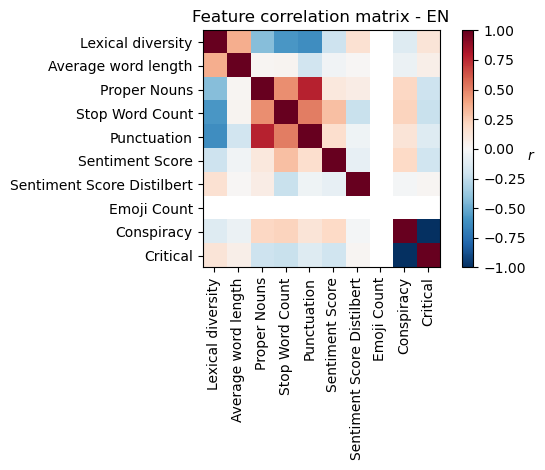

In [6]:
ax = plt.axes()
feature_names = ['Lexical diversity', 'Average word length', 'Proper Nouns', 'Stop Word Count', 'Punctuation','Sentiment Score', 'Sentiment Score Distilbert' , 'Emoji Count','Conspiracy', 'Critical', ]
df['lexical_div'] = df['text'].apply(lexical_diversity)
df['avg_word_len'] = df['text'].apply(avg_word_length)
df['conspiracy'] = df['category'].apply(lambda x : float(x=='CONSPIRACY'))
df['critical'] = df['category'].apply(lambda x : float(x=='CRITICAL'))
df['proper_nouns'] = df['text'].apply(proper_nouns)
df['punc_count'] = df['text'].apply(punc_count)
df['sentiment_score'] = df['text'].apply(sentiment_score)
df['sentiment_analysis_score'] = df['text'].apply(sentiment_analysis_score)
df['stop_word_count'] = df['text'].apply(stop_word_count)
df['emoji_count'] = df['text'].apply(emoji_count)
im = ax.imshow(np.corrcoef(df[['lexical_div', 'avg_word_len', 'proper_nouns', 'stop_word_count','punc_count','sentiment_score', 'sentiment_analysis_score','emoji_count', 'conspiracy', 'critical']].T), cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(list(range(len(feature_names))))
ax.set_xticklabels(feature_names, rotation=90)
ax.set_yticks(list(range(len(feature_names))))
ax.set_yticklabels(list(feature_names))

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Feature correlation matrix - EN")
plt.tight_layout()

## Spanish dataset

In [7]:

df_es = pd.read_json('data/dataset_es_train.json')

/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


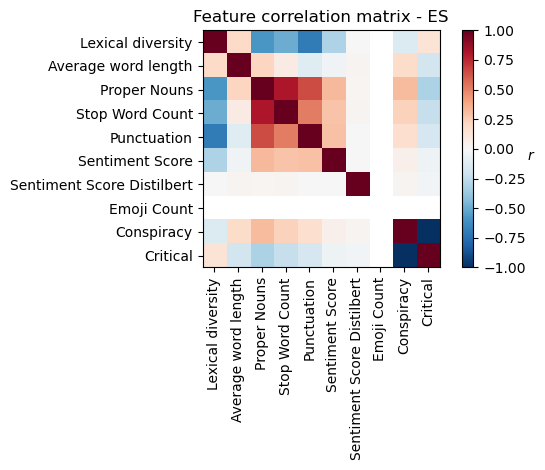

In [8]:
ax = plt.axes()
feature_names = ['Lexical diversity', 'Average word length', 'Proper Nouns', 'Stop Word Count', 'Punctuation','Sentiment Score', 'Sentiment Score Distilbert', 'Emoji Count','Conspiracy', 'Critical', ]
df_es['lexical_div'] = df_es['text'].apply(lexical_diversity)
df_es['avg_word_len'] = df_es['text'].apply(avg_word_length)
df_es['conspiracy'] = df_es['category'].apply(lambda x : float(x=='CONSPIRACY'))
df_es['critical'] = df_es['category'].apply(lambda x : float(x=='CRITICAL'))
df_es['proper_nouns'] = df_es['text'].apply(proper_nouns)
df_es['punc_count'] = df_es['text'].apply(punc_count)
df_es['sentiment_score'] = df_es['text'].apply(sentiment_score)
df_es['sentiment_analysis_score'] = df['text'].apply(sentiment_analysis_score)
df_es['stop_word_count'] = df_es['text'].apply(stop_word_count)
df_es['emoji_count'] = df_es['text'].apply(emoji_count)
im = ax.imshow(np.corrcoef(df_es[['lexical_div', 'avg_word_len', 'proper_nouns', 'stop_word_count','punc_count','sentiment_score', 'sentiment_analysis_score','emoji_count', 'conspiracy', 'critical']].T), cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(list(range(len(feature_names))))
ax.set_xticklabels(feature_names, rotation=90)
ax.set_yticks(list(range(len(feature_names))))
ax.set_yticklabels(list(feature_names))

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Feature correlation matrix - ES")
plt.tight_layout()